# Shape-detection 
This work is inspired by Andrew Ng's Specialization Course on Deep Learning. In particular, the fourth chapter dedicated to the Convolutional Neural Network and the Yolo algorithm described in the third week.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


Creiamo un semplice dataset di immagini banali (rettangoli). Ogni immagine avrà una dimensione massima 24x24 e conterrà fino a un massimo di N_bb oggetti con diverse gradazioni di colore. La loro dimensione varierà tra un minimo di 1x1 e un massimo 8x8. Se la gradazione di colore (0-255) è minore o maggiore di una certa soglia (nel nostro caso <64), l'oggetto non deve essere rilevato. 

Contestualmente definiamo anche i nostri bboxes (bounding boxes). Useremo 5 coordinate: una 'Pc' che indica la percentuale di confidenza della presenza di un oggetto, 'x' e 'y', per la posizione spaziale del vertice alto a sinistra e 'w' e 'h' per l'estensione (larghezza e altezza). 

In [0]:
N_imgs = 125000

# imagines side dimension
side_dim = 32 # 24

# objects min/max side dimensions
obj_min_dim = 2
obj_max_dim = 8 

# number of objects
N_bb = 4 # 4

# color thresholds
min_threshold = 0
max_threshold = 124

# confidence threshold
Pc_th = .0

# inizialization of images with a light gray color
imgs = np.ones((N_imgs, side_dim, side_dim,3)) * .9 
# inizialization of bounding boxes
bounding_boxes = np.zeros((N_imgs, N_bb, 5))

# inizialization of origin distance array
distance = np.zeros((N_imgs, N_bb))

# creationn of objects in images and relative bounding boxes

for N_img in range(N_imgs):
    for i_ogg in range(N_bb):
        w = np.random.randint(obj_min_dim, obj_max_dim)
        h = np.random.randint(obj_min_dim, obj_max_dim)
        x = np.random.randint(0, side_dim - w)
        y = np.random.randint(0, side_dim - h)
          
        R = (np.random.randint(min_threshold, max_threshold)) / 255
        G = (np.random.randint(min_threshold, max_threshold)) / 255
        B = (np.random.randint(min_threshold, max_threshold)) / 255
        
        imgs[N_img, y:y+h, x:x+w, 0] = R 
        imgs[N_img, y:y+h, x:x+w, 1] = G 
        imgs[N_img, y:y+h, x:x+w, 2] = B 
        
        '''
        if col >= min_threshold and col < max_threshold: 
          Pc = 1
        else: 
          Pc = 0
        '''
        Pc = 1
        bounding_boxes[N_img, i_ogg] = [Pc, x, y, w, h]   
        
        # calcoliamo la distanza dall'origine per ogni Bounding Box
        distance[N_img, i_ogg] = np.sqrt(np.square(x+(w/2))+ np.square(y+(h/2)))


## Osservazione e Pre-processing
Prima cosa che facciamo è analizzare i nostri dataset e cominciare a preprocessarli

In [3]:
# Osserviamo la dimensione degli array Numpy per immagini e bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
distance.shape

Dimension of images array: (125000, 32, 32, 3)
Dimension of BBoxes array: (125000, 4, 5)


(125000, 4)

Imagine n. 81603


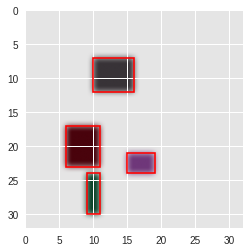

In [4]:
# Ora prendiamo un'immagine a caso
im = np.random.randint(N_imgs)
print('Imagine n.', im)

# Vediamo gli oggetti contenuti in essa...
fig, ax = plt.subplots(1)

ax.imshow(imgs[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...e i bounding box corrispondenti
for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

# consideriamo solo una percentuale di confidenza sopra la Pc_th  
# (nei nostri dataset abbiamo Pc con valori 0 oppure 1) ma in seguito 
# Pc assumerà valori probabilistici tra 0 e 1
  if Pc >= Pc_th:
    rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.6', fc='none')
    ax.add_patch(rect)

plt.show()

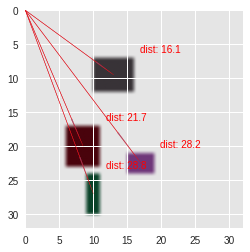

In [5]:
# Riossorviamo l'immagine di prima con la distanza dall'origine degli oggetti...
fig, ax = plt.subplots(1)

ax.imshow(imgs[im], origin = 'upper', interpolation = 'hanning', extent=[0, side_dim, side_dim, 0])

for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

  if Pc >= Pc_th:
    line = patches.Arrow(0, 0, x+(w/2), y+(h/2), .2, ec='r') 
    ax.add_patch(line)
    dida = 'dist: ' + '{:0.1f}'.format(distance[im,i])
    plt.annotate(dida, (x + w + 0.8 , y - 0.8), color='r')

plt.show()

In [0]:
# Riordiniamo i bounding_boxes in base alla distanza dall'origine degli oggetti

order = np.zeros((N_imgs, N_bb), dtype=int)
bboxes = np.zeros(bounding_boxes.shape)

for i in range(N_imgs):
  order[i] = np.argsort(distance[i]) 
  for j in range(N_bb):
    bboxes[i,j] = (bounding_boxes[i, order[i,j]])

Cominciamo a pensare in termini di Machine Learning,  normalizziamo perciò i valori dei pixel contenuti nelle nostre immagini per avere valori compresi tra -1 e 1 e li trasferiamo nei valori di input X. 

Analogamente normalizziamo i valori geometrici dei nostri bboxes rispetto alla dimensione delle immagini.    

In [7]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
X = np.reshape(X, (N_imgs, side_dim, side_dim, 3))
print(X.shape, np.mean(imgs), np.std(imgs))


Y = np.concatenate((bboxes[:,:, :1], (bboxes[:,:, 1:]/side_dim)), axis=-1)
Y = Y.reshape(N_imgs, -1) 
print(Y.shape)

(125000, 32, 32, 3) 0.8497515497957513 0.17910269727925016
(125000, 20)


In [8]:
# Osserviamo un esempio a cominciare dalle nostre X
i = np.random.randint(N_imgs)
print('Images example', i, 'has shape:\n', X[i].shape, '\n')

# Per poi osservare le nostre Y
print('...and the target values Y are:\n', Y[3])

Images example 30744 has shape:
 (32, 32, 3) 

...and the target values Y are:
 [1.      0.25    0.28125 0.1875  0.15625 1.      0.3125  0.53125 0.09375
 0.1875  1.      0.03125 0.6875  0.125   0.21875 1.      0.78125 0.59375
 0.125   0.0625 ]


Abbiamo un dataset omogeneo i 60 mila elementi che ora dividiamo in Training set, Validation set, e Test set in rapporto 80%, 10%, 10%

In [9]:
i = int(0.8 * N_imgs)
j = int(0.1 * N_imgs)

X_train = X[:i]
Y_train = Y[:i]
train_ex = X_train.shape[0]

X_val = X[i:i+j]
Y_val = Y[i:i+j]
val_ex = X_val.shape[0]

X_test = X[i+j:]
Y_test = Y[i+j:]
test_ex = X_test.shape[0]

dim_test = j # per futura memoria

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(100000, 32, 32, 3) (100000, 20) (12500, 32, 32, 3) (12500, 20) (12500, 32, 32, 3) (12500, 20)


In [28]:


model = Sequential()
model.add(Conv2D(48, kernel_size=(8, 8), strides=2, padding='same', activation='relu', input_shape=(side_dim,side_dim,3), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(96, kernel_size=(4, 4), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(384, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(Y.shape[-1]))

summ = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 96)          73824     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 192)         73920     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 192)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
__________

In [0]:
# sgd = optimizers.SGD(lr=0.0009, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.compile('adadelta', 'mse', metrics=['accuracy'])

In [0]:
def IoU(box1, box2):
  '''Intersection over Union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, with coordinates (x1, y1, w1, h1)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x1, y1, w1, h1] = box1
  [x2, y2, w2, h2] = box2
  
  
  
  # Intesection area 
  xi1 = np.maximum(x1, x2)
  yi1 = np.maximum(y1, y2)
  xi2 = np.minimum(x1+w1, x2+w2)
  yi2 = np.minimum(y1+h1, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)


  # Union area
  box1_area = (w1*h1)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/union_area

  return iou


In [55]:

model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), verbose=1)

Train on 100000 samples, validate on 12500 samples
Epoch 1/30
100000/100000 [==============================] - 41s 414us/step - loss: 0.0045 - acc: 0.2488 - val_loss: 0.0035 - val_acc: 0.4463
Epoch 2/30
100000/100000 [==============================] - 41s 413us/step - loss: 0.0044 - acc: 0.2550 - val_loss: 0.0035 - val_acc: 0.1701
Epoch 3/30
100000/100000 [==============================] - 41s 413us/step - loss: 0.0044 - acc: 0.2400 - val_loss: 0.0035 - val_acc: 0.0778
Epoch 4/30
100000/100000 [==============================] - 41s 413us/step - loss: 0.0044 - acc: 0.2578 - val_loss: 0.0035 - val_acc: 0.3676
Epoch 5/30
100000/100000 [==============================] - 42s 415us/step - loss: 0.0044 - acc: 0.2735 - val_loss: 0.0034 - val_acc: 0.2616
Epoch 6/30
100000/100000 [==============================] - 41s 414us/step - loss: 0.0043 - acc: 0.2901 - val_loss: 0.0034 - val_acc: 0.5793
Epoch 7/30
100000/100000 [==============================] - 41s 412us/step - loss: 0.0043 - acc: 0.2850

In [56]:
pred_y = model.predict(X_test)
pred_bboxes = pred_y
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)
pred_bboxes.shape
# print(pred_bboxes[1])

(12500, 4, 5)

Test images: 8774
Object:  1
B-box confidence: 1.000082
B-box coordinates: [1.53 5.81 5.47 4.46]
Object coordinates: [0. 6. 6. 5.]
Test images: 8774
Object:  2
B-box confidence: 1.0003103
B-box coordinates: [5.91 17.19 4.66 4.29]
Object coordinates: [ 7. 17.  7.  3.]
Test images: 8774
Object:  3
B-box confidence: 1.0002527
B-box coordinates: [13.01 18.69 4.21 4.47]
Object coordinates: [14. 20.  3.  5.]
Test images: 8774
Object:  4
B-box confidence: 0.9997961
B-box coordinates: [7.87 27.64 3.39 3.10]
Object coordinates: [10. 28.  2.  2.]


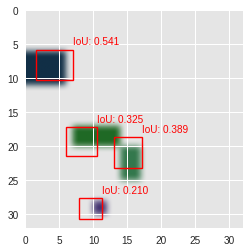

In [64]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Ora prendiamo un'immagine a caso
im = np.random.randint(j)



# Vediamo gli oggetti contenuti in essa...
# print(imgs[im])
fig, ax = plt.subplots(1)
ax.imshow(imgTest[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])
# ...e i bounding box corrispondenti

for i in range (N_bb):
  [Pc, x , y, w, h] = pred_bboxes[im, i]
  expected_box = Y_test[im,(i*5)+1:(i*5)+5]*side_dim 
  
  x *= side_dim
  y *= side_dim
  w *= side_dim
  h *= side_dim
   
  rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.4', fc='none')

  dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,w,h], expected_box))
  plt.annotate(dida, (x + w , y - 0.8), color='r')

  print('Test images:', im)
  print('Object: ', i+1)
  print('B-box confidence:', Pc)
  print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(w), '{:0.2f}]'.format(h))
  print('Object coordinates:', expected_box)

  ax.add_patch(rect)

plt.show()


In [59]:
name = 'model_4_100_0'
model_name = name + '.json' 
weight_name = name + 'p50.h5'

# serialize model to JSON
model_json = model.to_json()
with open(model_name, 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(weight_name)
print('Saved model to disk')


Saved model to disk


In [0]:
from keras import backend as K
from keras.models import model_from_json
K.clear_session()

In [45]:
# later...
 
# load json and create model
json_file = open(model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(weight_name)
print('Loaded model from disk')

Loaded model from disk


In [47]:
# evaluate loaded model on test data
model.compile('adadelta', 'mse', metrics=['accuracy'])
score = model.evaluate(X_train, Y_train, verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

100000/100000 [==============================] - 14s 139us/step
acc: 33.03%


In [0]:
def dist(box1, box2):
  distance = np.sqrt(np.sum(np.square(box1[:2] - box2[:2])))
  return distance   

In [0]:
def specialize(pred_bboxes, expe_bboxes, N_bb, sp_type, n_swap):
  '''Specialize bounding boxes on better IoU
    
  Arguments:
  pred_bboxes -- predicted bounding boxes (5 x N_bb)
  expe_bboxes -- expetcted bounding boxes (5 x N_bb)
  
  Returns:
  new_expe -- new order of expected bounding boxes (5xN_bb)
  '''    
  py = pred_bboxes.reshape(N_bb, -1) 
  yy = expe_bboxes.reshape(N_bb, -1)  
  
  mask_ = np.zeros((N_bb, N_bb)) 
  
  for i in range (N_bb):
    for j in range (N_bb):
      if sp_type == 'IoU':
        mask_[i,j] = IoU(yy[i,2:6], py[j,2:6])
      elif sp_type == 'O_d':
        mask_[i,j] = dist(yy[i,2:6], py[j,2:6])
      elif sp_type == 'mse':
        mask_ [i,j] = np.mean(np.square(py[i,2:6] - yy[i,2:6]))
    
  mask_ += .0001
  iou_m = np.zeros((N_bb), dtype=int)
  
  for i in range (N_bb):
    pos_iou = np.unravel_index(np.argmax(mask_), mask_.shape)
    iou_m[i] = pos_iou[1]
    mask_[pos_iou[0], :] = 0
    mask_[:, pos_iou[1]] = 0
  
  normal = 1. - np.mean(iou_m == np.arange(N_bb, dtype=int))
    
  if normal != 0:
    n_swap += normal/3*2
    yy = yy[iou_m]
  
  swapped = yy.reshape(-1)  

  return swapped, n_swap

In [0]:
n_swap = 0
swap_Y = Y_train
'''

'''

n_epoc = 10
for epoch in range(n_epoc):
  print('Epoch ', epoch+1,'/',n_epoc)                      
  model.fit(X_train, swap_Y, epochs=1, validation_data=(X_val, Y_val), verbose=1)
  
  pred_Y = model.predict(X_train)
  if epoch < n_epoc-1:
    n_sw = 0
    for i, (pred_bboxes, expe_bboxes) in enumerate(zip(pred_Y, swap_Y)):

      sp_type = 'mse'     #    'IoU' or 'O_d' or 'mse' 
      swapped, n_sw = specialize(pred_bboxes, expe_bboxes, N_bb, sp_type, n_sw)
      swap_Y[i] = swapped
    
    n_swap += n_sw
  print('Numero swap:', n_sw, 'Totale swap:', n_swap)
  print()
  
'''

'''


In [0]:
def mask_Pc(bboxes, Pc_th, N_bb):
  # creiamo una maschera che azzeri gli y che non servono alla rilevazione
  
  masked_Pc = np.zeros((bboxes.shape)) - .001
  masked_Pc[:,:,0] = Pc_th
  mask = masked_Pc < bboxes 
  for i in range(N_bb):
    for j in range(5):
      bboxes[:,i,j] = mask[:,i,0] * bboxes[:,i,j]

  return bboxes

new_Y = mask_Pc(bboxes, Pc_th, N_bb)


In [131]:
new_bboxes = mask_Pc(bboxes, Pc_th, N_bb)
print(new_bboxes.shape)

(12500, 3, 5)
